In [1]:
import cobra
from collections import defaultdict
import json
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
from urllib.request import urlopen

from mosmo.model import Molecule, Reaction, ReactionNetwork
from mosmo.calc import fba_gd

jax.config.update('jax_enable_x64', True)
prng = jax.random.PRNGKey(int(time.time() * 1000))

def labels(entries):
    return [entry.label for entry in entries]

## ecoli_core network solved by cobrapy

In [2]:
%%time
# iml1515 = json.loads(urlopen("http://bigg.ucsd.edu/static/models/iML1515.json").read())
cobra_model = cobra.io.load_model("textbook")
cobra_solution = cobra_model.optimize()
cobra_model.summary()

CPU times: user 188 ms, sys: 3.99 ms, total: 192 ms
Wall time: 198 ms


Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


## Construct the same FBA problem using ReactionNetwork and FbaGd

In [3]:
# Convert all bigg molecule dicts to Molecule objects
mols = {}
for cobra_mol in cobra_model.metabolites:
    mol = Molecule(
        id=cobra_mol.id,
        name=cobra_mol.name,
        formula=cobra_mol.formula,
        charge=cobra_mol.charge,
    )
    mols[mol.id] = mol

# Sort bigg reactions into "real" reactions, boundaries, and biomass components
reactions = {}
bounds = {}
biomass_components = {}
flux_targets = {}
for cobra_reaction in cobra_model.reactions:
    if len(cobra_reaction.metabolites) == 1:
        # Exchange => boundary molecule, with targets (lb, ub)
        mol = mols[next(iter(cobra_reaction.metabolites)).id]
        lb, ub = cobra_reaction.bounds
        lb = -np.inf if lb == -1000 else lb
        ub = np.inf if ub == 1000 else ub
        bounds[mol] = (lb, ub)
    elif cobra_reaction.id== "Biomass_Ecoli_core":
        # Biomass components, with targets
        for component, amount in cobra_reaction.metabolites.items():
            biomass_components[mols[component.id]] = -amount
    else:
        rxn = Reaction(
            id=cobra_reaction.id,
            name=cobra_reaction.name,
            stoichiometry={mols[mol.id]: count for mol, count in cobra_reaction.metabolites.items()},
            reversible=cobra_reaction.reversibility,
        )
        reactions[rxn.id] = rxn

        # Capture any non-trivial reaction flux targets (i.e. for ATPM)
        if cobra_reaction.lower_bound > 0 or cobra_reaction.upper_bound < 0:
            flux_targets[rxn] = cobra_reaction.bounds

network = ReactionNetwork(reactions.values())
intermediates = set(network.reactants) - bounds.keys() - biomass_components.keys()
print(f"{len(reactions)} reactions on {len(mols)} molecules")
print(f"{len(intermediates)} intermediates; {len(bounds)} boundaries; {len(biomass_components)} biomass components")
print(f"{len(flux_targets)} flux targets")

74 reactions on 72 molecules
29 intermediates; 20 boundaries; 23 biomass components
1 flux targets


### Basic constraints
- SteadyStateObjective for internal (non-boundary, _non-biomass_) reactants
- IrreversibilityObjective for irreversibility
- ProductionObjective for boundaries/exchanges
- VelocityObjective for flux targets
- BiomassObjective for biomass (requires growth rate as param)

Since we're using specific targets that are known to be achievable we should be able to get away with weighting all the objectives equally. But anticipating when the biomass objective is controlled by a variable to be optimized to a non-zero value, we should also look at how changing its weight affects the outcome

In [4]:
class BiomassObjective(fba_gd.Objective):
    def __init__(self, network, biomass_components, growth_rate, weight=1.0):
        super().__init__(weight)
        self.network = network
        self.indices = np.array([network.reactants.index_of(component) for component in biomass_components.keys()], dtype=np.int32)
        self.fractions = network.reactants.pack(biomass_components)[self.indices]
        self.growth_rate = growth_rate
    
    def params(self):
        return self.growth_rate
    
    def update_params(self, growth_rate):
        self.growth_rate = growth_rate

    def residual(self, velocities, dmdt, growth_rate):
        expected = growth_rate * self.fractions
        actual = dmdt[self.indices]
        return actual - expected

ss_objective = fba_gd.SteadyStateObjective(network, intermediates)
irrev_objective = fba_gd.IrreversibilityObjective(network)
bounds_objective = fba_gd.ProductionObjective(network, {target: (lb, ub) for target, (lb, ub) in bounds.items() if lb is not None or ub is not None})
flux_objective = fba_gd.VelocityObjective(network, flux_targets)
biomass_objective = BiomassObjective(network, biomass_components, cobra_solution.objective_value)

print(f"{len(ss_objective.indices)} steady-state targets")
print(f"{len(irrev_objective.indices)} irreversibility targets")
print(f"{len(bounds_objective.indices)} boundary targets")
print(f"{len(flux_objective.indices)} flux targets")
print(f"{len(biomass_objective.indices)} biomass targets")

29 steady-state targets
35 irreversibility targets
20 boundary targets
1 flux targets
23 biomass targets


In [5]:
%%time
problem = fba_gd.FbaGd(
    network, intermediates, {
        "boundaries": bounds_objective,
        "fluxes": flux_objective,
        "growth": biomass_objective,
    },
)
gd_soln = problem.solve(gtol=1e-15)
print(gd_soln.fit)

1.3760243100115478e-29
CPU times: user 1.31 s, sys: 15.3 ms, total: 1.32 s
Wall time: 485 ms


## Comparisons

In [6]:
fluxv_cobra = np.array(cobra_solution.fluxes[labels(network.reactions)])
fluxv_gd = gd_soln.velocities

flux_df = pd.DataFrame({
    rxn.id: {"cobra": flux_cobra, "fbagd": flux_gd}
    for rxn, flux_cobra, flux_gd in zip(network.reactions, fluxv_cobra, fluxv_gd)}).T
flux_df["diff"] = flux_df["cobra"] - flux_df["fbagd"]
flux_df["ratio"] = flux_df["cobra"] / flux_df["fbagd"]

dmdtv_cobra = network.s_matrix @ fluxv_cobra
dmdtv_gd = gd_soln.dmdt

dmdt_df = pd.DataFrame({
    mol.id: {"cobra": dmdt_cobra, "fbagd": dmdt_gd}
    for mol, dmdt_cobra, dmdt_gd in zip(network.reactants, dmdtv_cobra, dmdtv_gd)}).T
dmdt_df["diff"] = dmdt_df["cobra"] - dmdt_df["fbagd"]
dmdt_df["ratio"] = dmdt_df["cobra"] / dmdt_df["fbagd"]

### Assessment of steady state

In [7]:
(dmdt_df.loc[labels(intermediates)]**2).sum()

cobra    5.302964e-28
fbagd    1.376024e-29
diff     5.454031e-28
ratio             inf
dtype: float64

### Agreement on exchanges/boundaries and reaction flux

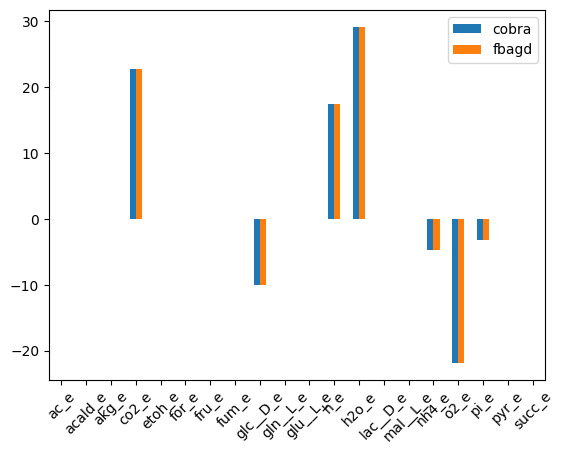

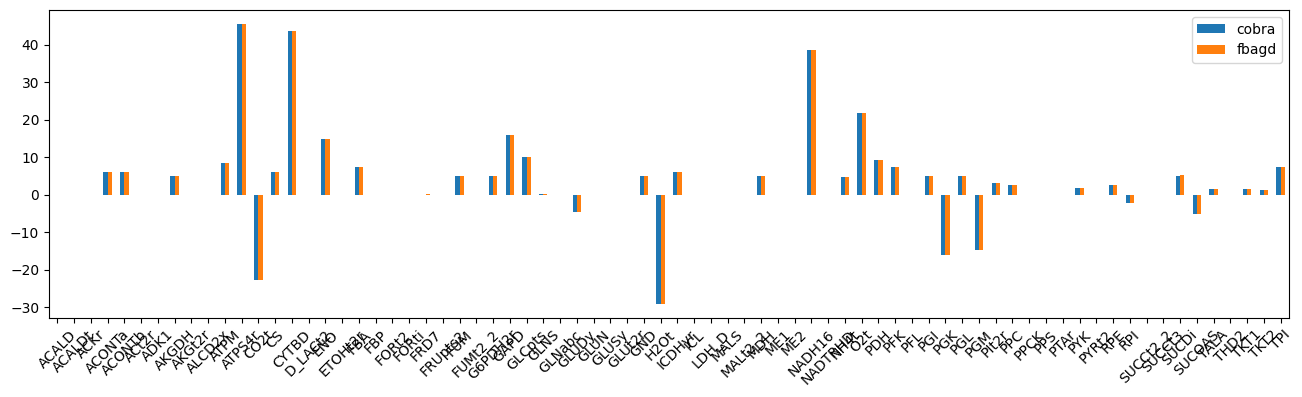

Significant differences:


,cobra,fbagd,diff,ratio
FRD7,0.000000,0.064026,-0.064026,0.000000
SUCDi,5.064376,5.128402,-0.064026,0.987515


In [8]:
dmdt_df.loc[labels(bounds.keys())][["cobra", "fbagd"]].plot.bar(rot=45)
flux_df[["cobra", "fbagd"]].plot.bar(figsize=(16,4),rot=45)
plt.show()

print("Significant differences:")
flux_df.loc[
    np.logical_and(flux_df["diff"].abs() > 0.01, (flux_df["ratio"] - 1).abs() > 0.01)
]

In other words, more or less identical. Which is interesting, since it means there is no redundancy, no alternative paths to the same result. And no unconstrained futile cycles.

## Maximize growth as an objective

### First: what happens with growth rate on either side of the LP-determined optimum?

In [9]:
%%time
results = []
residuals = {name: [] for name in problem.objectives.keys()}
for delta in np.linspace(-.5, +.5, 21):
    # Adjust growth rate and solve
    growth_rate = cobra_solution.objective_value + delta
    problem.update_params({"growth": growth_rate})
    soln = problem.solve(gtol=1e-15)

    results.append((growth_rate, soln))    
    for name, objective in problem.objectives.items():
        residuals[name].append(np.sum(np.square(objective.residual(soln.velocities, soln.dmdt, objective.params()))))
problem.update_params({"growth": cobra_solution.objective_value})  # restore the growth rate when we're done

growthv = np.array([result[0] for result in results])
fluxv = np.array([result[1].velocities for result in results])
dmdtv = np.array([result[1].dmdt for result in results])

CPU times: user 8.33 s, sys: 2.82 ms, total: 8.33 s
Wall time: 1.25 s


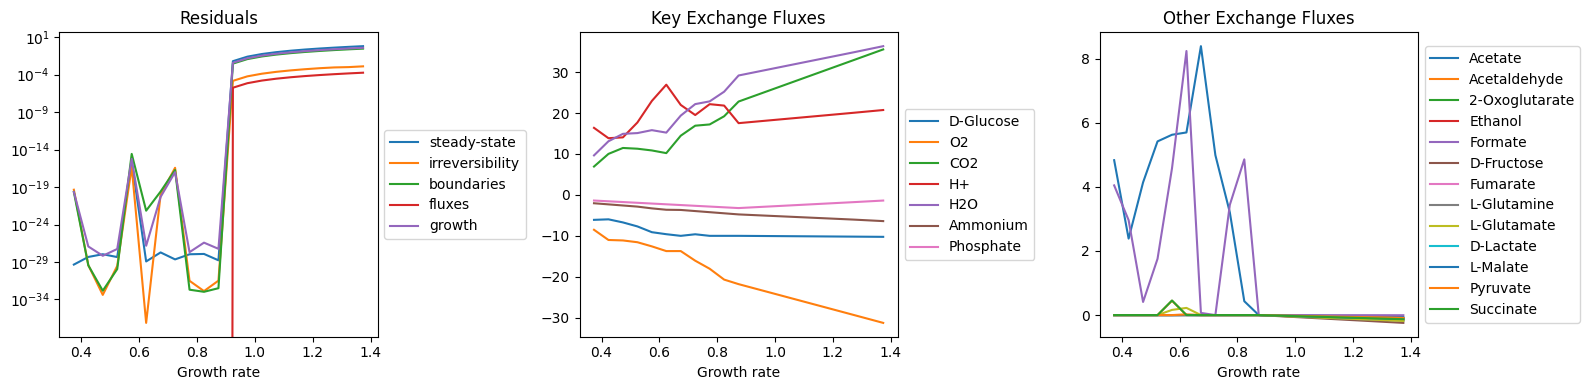

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for name, scores in residuals.items():
    ax[0].plot(growthv, scores, label=name)
ax[0].set_yscale("log")
# ax[0].set_ylim(1e-12, 1e0)
ax[0].set_title("Residuals")
ax[0].set_xlabel("Growth rate")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

key_species = [mols[id] for id in ("glc__D_e", "o2_e", "co2_e", "h_e", "h2o_e", "nh4_e", "pi_e")]
for mol in key_species:
    ax[1].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[1].set_title("Key Exchange Fluxes")
ax[1].set_xlabel("Growth rate")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for mol in bounds:
    if mol not in key_species:
        ax[2].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[2].set_title("Other Exchange Fluxes")
ax[2].set_xlabel("Growth rate")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

- Fit error jumps sharply at the LP optimimum, this is a good sign
- Glucose uptake increases steadily until the optimimum, then flattens
- Solutions are variable up to the optimum, more tightly constrained after that
    - This includes secreting e.g. Formate or Acetate, which are absent from the optimal solution
- In the faster growth solutions, the ratios of CO2, O2, H+ and H2O in/out change
    - Specifically, O2 -> CO2 increases more rapidly than H2O or H+. Interpret this as shifting from OxPhos to other ATP production?

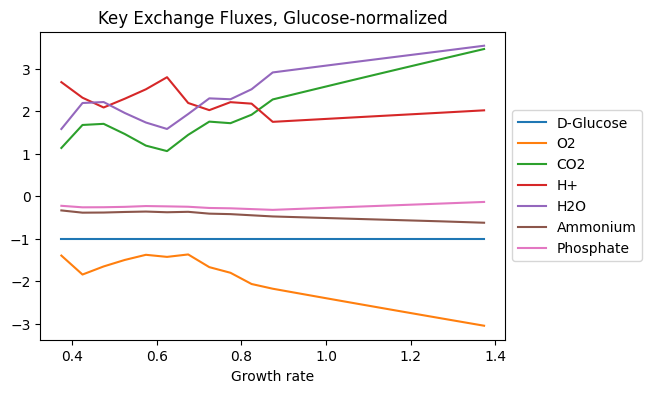

In [11]:
glc_normalized = (dmdtv.T / -dmdtv.T[network.reactants.index_of(mols["glc__D_e"])]).T
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for mol in key_species:
    ax.plot(growthv, glc_normalized[:, network.reactants.index_of(mol)], label=mol.name)
ax.set_title("Key Exchange Fluxes, Glucose-normalized")
ax.set_xlabel("Growth rate")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Finer scale near optimal growth rate

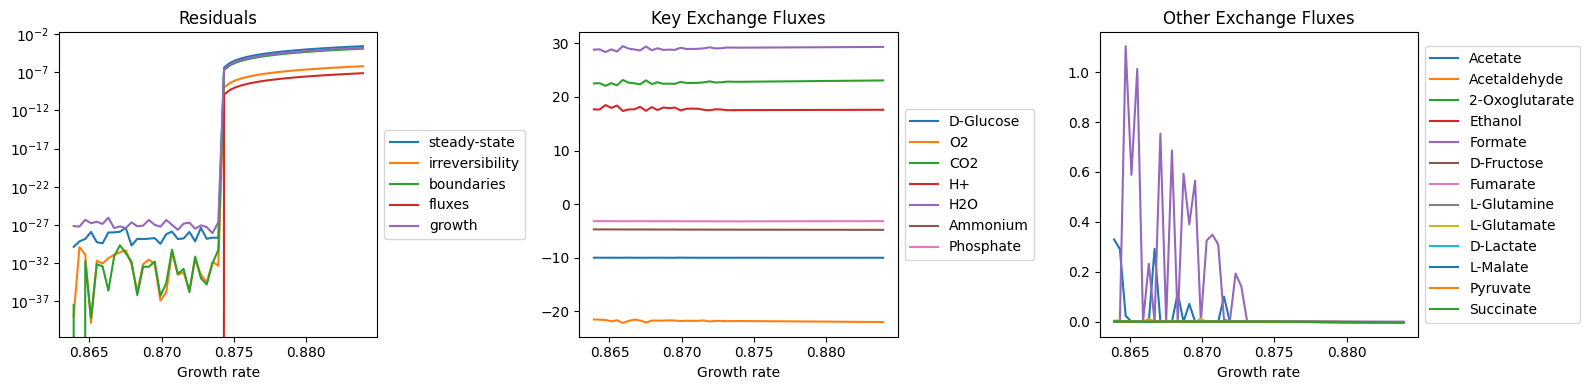

In [12]:
results = []
residuals = {name: [] for name in problem.objectives.keys()}
for delta in np.linspace(-.01, +.01, 51):
    # Adjust growth rate and solve
    growth_rate = cobra_solution.objective_value + delta
    problem.update_params({"growth": growth_rate})
    soln = problem.solve(gtol=1e-15)

    results.append((growth_rate, soln))    
    for name, objective in problem.objectives.items():
        residuals[name].append(np.sum(np.square(objective.residual(soln.velocities, soln.dmdt, objective.params()))))
problem.update_params({"growth": cobra_solution.objective_value})  # restore the growth rate when we're done

growthv = np.array([result[0] for result in results])
fluxv = np.array([result[1].velocities for result in results])
dmdtv = np.array([result[1].dmdt for result in results])

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for name, scores in residuals.items():
    ax[0].plot(growthv, scores, label=name)
ax[0].set_yscale("log")
# ax[0].set_ylim(1e-12, 1e0)
ax[0].set_title("Residuals")
ax[0].set_xlabel("Growth rate")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

key_species = [mols[id] for id in ("glc__D_e", "o2_e", "co2_e", "h_e", "h2o_e", "nh4_e", "pi_e")]
for mol in key_species:
    ax[1].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[1].set_title("Key Exchange Fluxes")
ax[1].set_xlabel("Growth rate")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for mol in bounds:
    if mol not in key_species:
        ax[2].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[2].set_title("Other Exchange Fluxes")
ax[2].set_xlabel("Growth rate")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

### Strategies
- If we lump everything into one objective function, we need to weight minimizing error _way_ higher than maximizing growth. This uses the jump in the first graph as a hard stop not to push growth higher. Even at fine scale, this error gradient is very steep. We should be able to take advantage of that.
- Other possible signals (maybe not as sharp as the error signal)
    - Use glucose uptake not as a limit, but as an exact target. Justification: matching an observed quantity
    - Also put targets on low or zero secretion of acetate, formate, maybe others. Jusification: efficient growth
    - Constrain ratios of glucose, O2, CO2, water
- Alternative: Constrain biomass _ratios_, but do not explicitly maximize growth. With some of the other constaints above this may guide us to the same transition point without having to arbitrarily balance maximizing growth vs minimizing error in the objective

### Explicitly maximize growth
- Since we are not pushing an error to zero, but pushing growth rate to a non-zero maximum, we need to rebuild the whole approach around minimize() instead of least_squares()
    - If this is successful of course we can build this into FbaGd
- Underweight contribution of growth rate, but make it significant enough to overcome fluctuation in the 'fitness' objectives.

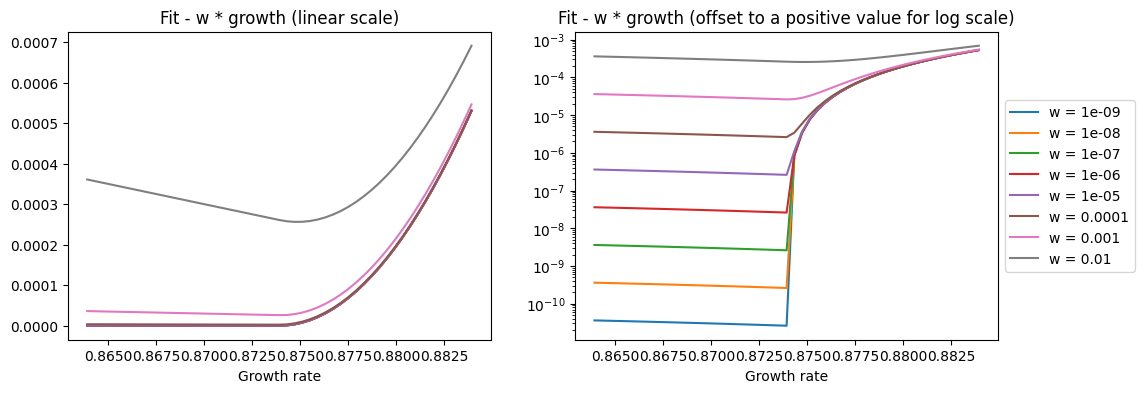

In [13]:
fitv = np.array([scores for scores in residuals.values()]).sum(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for w in [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    ax[0].plot(growthv, fitv - growthv * w + w * 0.9, label=f"w = {w}")
    ax[1].plot(growthv, fitv - growthv * w + w * 0.9, label=f"w = {w}")
ax[0].set_xlabel("Growth rate")
ax[1].set_xlabel("Growth rate")
ax[0].set_title("Fit - w * growth (linear scale)")
ax[1].set_title("Fit - w * growth (offset to a positive value for log scale)")
ax[1].set_yscale("log")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

- At higher weights, the left-side gradient is steeper but the minimum is noticeably shifted right
- At lower weights the transition is sharp and at the desired optimum, but the left-side gradient may be too shallow, or not smooth enough

## Different Tack: constrained minimization

- Basic constraints go in a single function (L1 or L2) passed to minimize(constraint=)
  - steady state
  - irreversibility / flux bounds
    - pull ATP maintenance into a separate objective? mathematically moot
  - biomass function, governed by growth rate variable
  - boundary targets (?)
- "Main" function passed to minimize(fun=) is simply the biomass growth rate (as a negative)

In [14]:
class MultiObjective:
    def __init__(self, objectives):
        self.objectives = {name: objective for name, objective in objectives.items()}
    
    def residuals(self, velocities, dmdt, params=None):
        params = params or {}
        result = {}
        for name, objective in self.objectives.items():
            param = params.get(name)
            if param is None:
                param = objective.params()
            result[name] = objective.residual(velocities, dmdt, param)
        return result

objectives = MultiObjective({
    "steady-state": ss_objective,
    "irrev": irrev_objective,
    "bounds": bounds_objective,
    "fluxes": flux_objective,
    "growth": biomass_objective
})

def residuals(x):
    growth_rate = x[0].astype(float)
    velocities = x[1:]
    dmdt = network.s_matrix @ velocities
    return jnp.concatenate(list(objectives.residuals(velocities, dmdt, {"growth": growth_rate}).values()))

constr_jit = jax.jit(residuals)
constr_jac = jax.jit(jax.jacfwd(residuals))
constr_hess = jax.jit(jax.jacfwd(constr_jac))

### Before invoking minimize(), confirm expected behavior compared to cobra

In [15]:
res = objectives.residuals(fluxv_cobra, dmdtv_cobra)
for name, residual in res.items():
    print(name, residual)
print()

x = jnp.insert(fluxv_cobra, 0, cobra_solution.objective_value)
res_full = jnp.concatenate(list(res.values()))
# print(jnp.all(constr_jit(x) == res_full))
print(jnp.sum(jnp.square((constr_jit(x) - res_full))))

steady-state [ 8.88178420e-16 -8.88178420e-16 -7.10542736e-15 -3.55271368e-15
  0.00000000e+00  8.88178420e-16 -7.49400542e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.97974444e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.31088724e-30
  0.00000000e+00  7.10542736e-15  0.00000000e+00 -3.55271368e-15
  0.00000000e+00  2.22044605e-16  0.00000000e+00 -2.22044605e-16
  0.00000000e+00  0.00000000e+00  8.88178420e-16  0.00000000e+00
  2.88516672e-15]
irrev [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
bounds [-3.19221472e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.77635684e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
fluxes [0.]
growth [ 1.99840144e-15  0.00000000e+00  5.32907052e-13

### Same as above, monitor behavior over range of growth rates

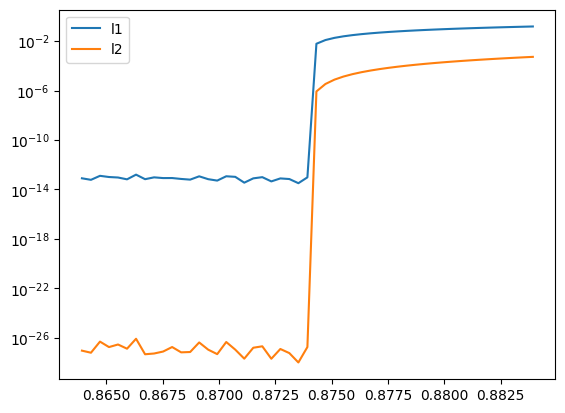

In [16]:
def assess(growth_rate, fba_result):
    x = jnp.insert(fba_result.velocities, 0, growth_rate)
    res_full = constr_jit(x)
    return {
        "growth": growth_rate,
        "l1": jnp.sum(jnp.abs(res_full)),
        "l2": jnp.sum(jnp.square(res_full))
    }
assess_df = pd.DataFrame(assess(*result) for result in results)
plt.plot(assess_df["growth"], assess_df["l1"], label="l1")
plt.plot(assess_df["growth"], assess_df["l2"], label="l2")
plt.yscale("log")
plt.legend()
plt.show()

## Finally, try minimize()
- x[0] is growth rate, x[1:] is v
- Constraints go in an instance of scipy.optimize.NonLinearContraint
- The "function" to minimize returns -x[0] -- jacobian (grad) and hessian are trivial

In [17]:
xlen = 1 + network.shape[1]
x0=jax.random.uniform(prng, shape=(xlen,))
jac_const = -jnp.eye(xlen)[0]
hess_const = jnp.zeros(xlen)
lb = np.array([0] + [-np.inf] * network.shape[1])
ub = np.full(xlen, np.inf)

soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=lambda x: -x[0].astype(float),
    jac=lambda x: jac_const,
    hess=lambda x: hess_const,
    x0=x0,
    bounds=scipy.optimize.Bounds(lb=lb, ub=ub, keep_feasible=True),
    constraints=scipy.optimize.NonlinearConstraint(
        fun=constr_jit,
        jac=constr_jac,
        # hess=constr_hess,  TODO: figure out this Hessian stuff
        lb=0,
        ub=0,
    ),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = network.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(residuals(soln.x)))}")
print()
objectives.residuals(velocities, dmdt, {"growth": growth_rate})


/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:81: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


Growth rate = 2.345550597743964e-13
Loss = 367.7310219472095



{'steady-state': array([ 0.05275841,  1.52977104,  0.20218648,  0.10444604, -0.5776485 ,
         0.0278355 ,  0.43924313, -1.18512283, -0.29033113, -0.14582578,
        -0.77161515,  0.75834922,  0.36108963,  0.5683829 ,  0.67425464,
        -0.35012684, -0.61964411, -0.20218648,  0.18945404,  1.03060779,
         0.37499758, -0.46053656,  1.2787252 ,  0.0315427 , -1.19591894,
         0.2071901 ,  0.08444661,  5.09504709,  0.72891208]),
 'irrev': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=float64),
 'bounds': Array([-0.0298652 , -0.54770832, -0.78368858,  0.        , -0.18945609,
        -0.04764459, -0.4040909 , -0.91141459,  0.        , -0.3931529 ,
        -0.49989839,  0.        ,  0.        , -0.7495503 , -0.31052378,
         0.        ,  0.        ,  0.        , -0.93378967,  0.        ],      dtype=float64),
 'fluxes': Array([-7.5217471], dtype=float6

### Focus on a much smaller problem to debug this

In [18]:
list(enumerate(network.reactions))

[(0, [ACALD] acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c),
 (1, [ACALDt] acald_e <=> acald_c),
 (2, [ACKr] ac_c + atp_c <=> actp_c + adp_c),
 (3, [ACONTa] cit_c <=> acon_C_c + h2o_c),
 (4, [ACONTb] acon_C_c + h2o_c <=> icit_c),
 (5, [ACt2r] ac_e + h_e <=> ac_c + h_c),
 (6, [ADK1] amp_c + atp_c <=> 2.0 adp_c),
 (7, [AKGDH] akg_c + coa_c + nad_c => co2_c + nadh_c + succoa_c),
 (8, [AKGt2r] akg_e + h_e <=> akg_c + h_c),
 (9, [ALCD2x] etoh_c + nad_c <=> acald_c + h_c + nadh_c),
 (10, [ATPM] atp_c + h2o_c => adp_c + h_c + pi_c),
 (11, [ATPS4r] adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c),
 (12, [CO2t] co2_e <=> co2_c),
 (13, [CS] accoa_c + h2o_c + oaa_c => cit_c + coa_c + h_c),
 (14, [CYTBD] 2.0 h_c + 0.5 o2_c + q8h2_c => h2o_c + 2.0 h_e + q8_c),
 (15, [D_LACt2] h_e + lac__D_e <=> h_c + lac__D_c),
 (16, [ENO] 2pg_c <=> h2o_c + pep_c),
 (17, [ETOHt2r] etoh_e + h_e <=> etoh_c + h_c),
 (18, [FBA] fdp_c <=> dhap_c + g3p_c),
 (19, [FBP] fdp_c + h2o_c => f6p_c + pi_c),
 (20, [FORt2]

In [19]:
baby = ReactionNetwork([network.reactions[52], network.reactions[50], network.reactions[18], network.reactions[73]])
pd.DataFrame(baby.s_matrix, index=labels(baby.reactants), columns=labels(baby.reactions))

,PGI,PFK,FBA,TPI
g6p_c,-1.0,0.0,0.0,0.0
f6p_c,1.0,-1.0,0.0,0.0
atp_c,0.0,-1.0,0.0,0.0
adp_c,0.0,1.0,0.0,0.0
fdp_c,0.0,1.0,-1.0,0.0
h_c,0.0,1.0,0.0,0.0
dhap_c,0.0,0.0,1.0,-1.0
g3p_c,0.0,0.0,1.0,1.0


In [20]:
b_objectives = MultiObjective({
    "steady-state": fba_gd.SteadyStateObjective(baby, [baby.reactants[1], baby.reactants[4]], weight=1e4),
    "irrev": fba_gd.IrreversibilityObjective(baby, weight=1e4),
    "bounds": fba_gd.ProductionObjective(baby, {baby.reactants[0]: (-10., 0), baby.reactants[6]: (0, None)}, weight=1e2),
    "growth": BiomassObjective(baby, {baby.reactants[7]: 1.}, 1.)
})

def b_residuals(x):
    growth_rate = x[0].astype(float)
    velocities = x[1:]
    dmdt = baby.s_matrix @ velocities
    return jnp.concatenate(list(b_objectives.residuals(velocities, dmdt, {"growth": growth_rate}).values()))

In [21]:
bx2 = jnp.array([2., 1., 1., 1., 1])
b_residuals(bx2)

Array([0., 0., 0., 0., 0., 0.], dtype=float64)

In [22]:
v = np.array([1, 1, 1, .5])
print(baby.reactions.unpack(v))
print(baby.reactants.unpack(baby.s_matrix @ v))

{[PGI] g6p_c <=> f6p_c: np.float64(1.0), [PFK] atp_c + f6p_c => adp_c + fdp_c + h_c: np.float64(1.0), [FBA] fdp_c <=> dhap_c + g3p_c: np.float64(1.0), [TPI] dhap_c <=> g3p_c: np.float64(0.5)}
{[g6p_c] D-Glucose 6-phosphate: np.float64(-1.0), [f6p_c] D-Fructose 6-phosphate: np.float64(0.0), [atp_c] ATP: np.float64(-1.0), [adp_c] ADP: np.float64(1.0), [fdp_c] D-Fructose 1,6-bisphosphate: np.float64(0.0), [h_c] H+: np.float64(1.0), [dhap_c] Dihydroxyacetone phosphate: np.float64(0.5), [g3p_c] Glyceraldehyde 3-phosphate: np.float64(1.5)}


In [23]:
bxlen = 1 + baby.shape[1]
bx0=jax.random.uniform(prng, shape=(bxlen,))
bjac_const = -jnp.eye(bxlen)[0]
blb = np.array([0] + [-np.inf] * baby.shape[1])
bub = np.full(bxlen, np.inf)

def bfun(x):
    return -x[0].astype(float)

bconstr_jit = jax.jit(b_residuals)
bconstr_jac = jax.jit(jax.jacfwd(b_residuals))

soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=jax.jit(bfun),
    jac=jax.jit(jax.jacfwd(bfun)),
    x0=bx0,
    bounds=scipy.optimize.Bounds(lb=blb, ub=bub, keep_feasible=True),
    constraints=scipy.optimize.NonlinearConstraint(
        fun=bconstr_jit,
        jac=bconstr_jac,
        lb=0,
        ub=0,
    ),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = baby.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(b_residuals(soln.x)))}")
print()
b_objectives.residuals(velocities, dmdt, {"growth": growth_rate})


Growth rate = 0.7817812772940215
Loss = 0.0



/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:81: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero inste

{'steady-state': array([0., 0.]),
 'irrev': Array([0.], dtype=float64),
 'bounds': Array([0., 0.], dtype=float64),
 'growth': array([0.])}

In [24]:
baby.reactions.unpack(soln.x[1:])

{[PGI] g6p_c <=> f6p_c: np.float64(0.39089063864701074),
 [PFK] atp_c + f6p_c => adp_c + fdp_c + h_c: np.float64(0.39089063864701074),
 [FBA] fdp_c <=> dhap_c + g3p_c: np.float64(0.39089063864701074),
 [TPI] dhap_c <=> g3p_c: np.float64(0.39089063864701074)}

In [25]:
baby.reactants.unpack(baby.s_matrix @ soln.x[1:])

{[g6p_c] D-Glucose 6-phosphate: np.float64(-0.39089063864701074),
 [f6p_c] D-Fructose 6-phosphate: np.float64(0.0),
 [atp_c] ATP: np.float64(-0.39089063864701074),
 [adp_c] ADP: np.float64(0.39089063864701074),
 [fdp_c] D-Fructose 1,6-bisphosphate: np.float64(0.0),
 [h_c] H+: np.float64(0.39089063864701074),
 [dhap_c] Dihydroxyacetone phosphate: np.float64(0.0),
 [g3p_c] Glyceraldehyde 3-phosphate: np.float64(0.7817812772940215)}

This is not working. There is plenty of room to increase the growth rate without violating the constraints.
- Confirm this: flux, dm/dt and loss over a wide range of growth rates

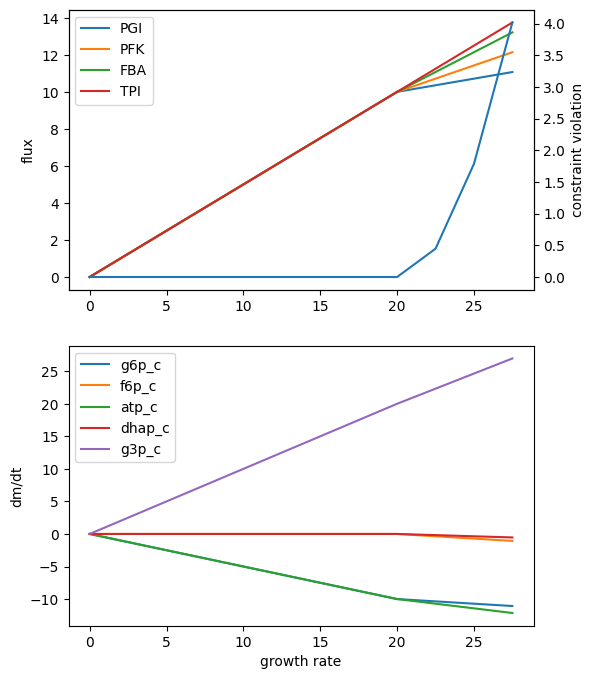

In [26]:
bfba = fba_gd.FbaGd(
    baby,
    intermediates = [baby.reactants[i] for i in b_objectives.objectives["steady-state"].indices],
    objectives={name: objective for name, objective in b_objectives.objectives.items() if name in ["bounds", "growth"]},
    w_fitness=1e4,
)
results = []
for growth_rate in np.arange(0, 30, 2.5):
    result = {"growth_rate": growth_rate}

    bfba.update_params({"growth": growth_rate})
    bsoln = bfba.solve(gtol=1e-12)
    for r, flux in baby.reactions.unpack(bsoln.velocities).items():
        result[r.id] = flux
    for m, d in baby.reactants.unpack(bsoln.dmdt).items():
        result[m.id] = d
    for name, resid in b_objectives.residuals(bsoln.velocities, bsoln.dmdt, {"growth": growth_rate}).items():
        result[name] = np.sum(np.square(resid))
    results.append(result)
results_df = pd.DataFrame(results).set_index("growth_rate")

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].set_ylabel("flux")
for rxn_id in ["PGI", "PFK", "FBA", "TPI"]:
    ax[0].plot(results_df.index, results_df[rxn_id], label=rxn_id)
ax[0].legend()

rax = ax[0].twinx()
rax.set_ylabel("constraint violation")
rax.plot(results_df.index, results_df[b_objectives.objectives.keys()].sum(axis=1))

ax[1].set_ylabel("dm/dt")
for met_id in ["g6p_c", "f6p_c", "atp_c", "dhap_c", "g3p_c"]:
    ax[1].plot(results_df.index, results_df[met_id], label=met_id)
ax[1].set_xlabel("growth rate")
ax[1].legend()
plt.show()

### Try it with LinearConstraint
- Pretty far afield of FbaGd code, and not so different from constructing an LP problem. But try it anyway

In [27]:
col_bounds = [(0, np.inf)]   # growth rate
for rxn in baby.reactions:
    if rxn.reversible:
        col_bounds.append((-np.inf, np.inf))
    else:
        col_bounds.append((0, np.inf))
col_bounds = np.array(col_bounds).T
bbounds = scipy.optimize.Bounds(lb=col_bounds[0], ub=col_bounds[1])

rows = []
row_bounds = []
for i in b_objectives.objectives["steady-state"].indices:
    rows.append(i)
    row_bounds.append((0, 0))
for i, (lb, ub) in zip(b_objectives.objectives["bounds"].indices, b_objectives.objectives["bounds"].bounds.T):
    rows.append(i)
    row_bounds.append((lb, ub))

biomass_frac = -baby.reactants.pack({baby.reactants[7]: 1.})[:, np.newaxis]
aug_matrix = np.hstack([biomass_frac, baby.s_matrix])
constraints = [
    scipy.optimize.LinearConstraint(aug_matrix[b_objectives.objectives["steady-state"].indices], lb=0, ub=0),
    scipy.optimize.LinearConstraint(aug_matrix[b_objectives.objectives["growth"].indices], lb=0, ub=0),
    scipy.optimize.LinearConstraint(
        aug_matrix[b_objectives.objectives["bounds"].indices], 
        lb=b_objectives.objectives["bounds"].bounds[0],
        ub=b_objectives.objectives["bounds"].bounds[1]),
]
row_bounds = np.array(row_bounds).T
lconstr = scipy.optimize.LinearConstraint(aug_matrix[rows], lb=row_bounds[0], ub=row_bounds[1])

In [28]:
%%time
hessp = np.zeros_like(bx0)
soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=jax.jit(bfun),
    jac=jax.jit(jax.jacfwd(bfun)),
    hessp=lambda x, v: hessp,
    x0=bx0,
    bounds=scipy.optimize.Bounds(lb=col_bounds[0], ub=col_bounds[1]),
    constraints=scipy.optimize.LinearConstraint(aug_matrix[rows], lb=row_bounds[0], ub=row_bounds[1]),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = baby.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(b_residuals(soln.x)))}")
print()
b_objectives.residuals(velocities, dmdt, {"growth": growth_rate})


Growth rate = 2003312.625906726
Loss = 4015780429470.9844

CPU times: user 1.11 s, sys: 4 ms, total: 1.11 s
Wall time: 1.11 s


{'steady-state': array([0.00000000e+00, 3.55271368e-15]),
 'irrev': Array([0.], dtype=float64),
 'bounds': Array([0., 0.], dtype=float64),
 'growth': array([-2003941.22405598])}

In [29]:
col_bounds = [(0, np.inf)]   # growth rate
for rxn in network.reactions:
    if rxn in flux_targets:
        col_bounds.append(flux_targets[rxn])
    elif rxn.reversible:
        col_bounds.append((-np.inf, np.inf))
    else:
        col_bounds.append((0, np.inf))
col_bounds = np.array(col_bounds).T

rows = []
row_bounds = []
for i in objectives.objectives["steady-state"].indices:
    rows.append(i)
    row_bounds.append((0, 0))
for i, (lb, ub) in zip(objectives.objectives["bounds"].indices, objectives.objectives["bounds"].bounds.T):
    rows.append(i)
    row_bounds.append((lb, ub))

biomass_frac = np.zeros((network.shape[0], 1))
for i, frac in zip(objectives.objectives["growth"].indices, objectives.objectives["growth"].fractions):
    biomass_frac[i, 0] = -frac
    rows.append(i)
    row_bounds.append((0, 0))

aug_matrix = np.hstack([biomass_frac, network.s_matrix])
row_bounds = np.array(row_bounds).T


In [30]:
%%time
xlen = 1 + network.shape[1]
x0=jax.random.uniform(prng, shape=(xlen,))
jac = -jnp.eye(xlen)[0]
hessp = np.zeros(xlen)

soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=lambda x: -x[0].astype(float),
    jac=lambda x: jac,
    hessp=lambda x, v: hessp,
    x0=x0,
    bounds=scipy.optimize.Bounds(lb=col_bounds[0], ub=col_bounds[1]),
    constraints=scipy.optimize.LinearConstraint(aug_matrix[rows], lb=row_bounds[0], ub=row_bounds[1]),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = network.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(residuals(soln.x)))}")
print()
objectives.residuals(velocities, dmdt, {"growth": growth_rate})


/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:81: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


Growth rate = -0.1606587434354876
Loss = 18.866854746421208

CPU times: user 15min 18s, sys: 499 ms, total: 15min 19s
Wall time: 1min 57s


{'steady-state': array([ 0.01058801,  0.470129  ,  0.07149836,  0.02821688, -0.18055529,
         0.01507534,  0.12904478, -0.3595338 , -0.08406055, -0.04912192,
        -0.23870696,  0.23643084,  0.10050658,  0.16672829,  0.20651848,
        -0.11480232, -0.18884402, -0.07149836,  0.05503617,  0.31035289,
         0.11970313, -0.141779  ,  0.40214816,  0.00582478, -0.36955518,
         0.06196006,  0.02028508,  1.53056737,  0.22820359]),
 'irrev': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=float64),
 'bounds': Array([ 0.        ,  0.        , -0.33798763,  0.        ,  0.        ,
         0.        , -0.07655469, -0.32228384,  0.        , -0.22622656,
         0.        ,  0.        ,  0.        ,  0.        , -0.15453029,
         0.        ,  0.        ,  0.        , -0.11187329,  0.        ],      dtype=float64),
 'fluxes': Array([-2.19991673], dtype=float

So the _concept_ of constrained minimization works just fine. But something is not as desired with NonLinearConstraint. Maybe that's just fine: most of the constraints on v or dmdt can be expressed that way. It is less flexible API-wise though. Or at least it will take some serious rethinking.